In [0]:
!pip install filterpy
import numpy as np
from numpy import dot
from math import sqrt, sin, cos, tan
from filterpy.kalman import ExtendedKalmanFilter as EKF
import matplotlib.pyplot as plt
from filterpy.stats import plot_covariance_ellipse

In [0]:
def calc_F(s, dt, u):
    '''
    Calculate the jacobian of the process function with repect to state 
    variables, conditioned on the current state.
    Input: current state s, time interval dt and control input u. Return 
    the F matrix for updating P. 
    '''
    theta = s[2]
    dist = dt * (u[0] + u[1]) * r / 2
    F = [[1, 0, -1* dist * np.sin(theta), 0], [0, 1, dist * np.cos(theta), 0], 
         [0, 0, 1, 0], [0, 0, 0, 0]]
    return np.array(F)

In [0]:
def calc_V(s, dt, u):
    '''
    Calculate the jacobian of the process function with respect to the 
    control input, conditioned on the current state.
    Input: current state s, time interval dt and control input u. Return 
    the V matrix for updating P. 
    '''
    theta = s[2]
    V1 = dt * r * np.cos(theta) / 2
    V2 = dt * r * np.sin(theta) / 2
    V3 = dt * r / l
    V4 = r / l
    V = [[V1, V1], [V2, V2], [V3, -1 * V3], [0, 0]]
    return np.array(V)

In [0]:
def H_of(s):
    """ 
    Compute H, the Jacobian of the measurment matrix where h(s) computes 
    the range toward front wall and right wall for state s 
    """
    x = s[0]
    y = s[1]
    xf , yf = straight_intersection_point(s)
    xr , yr = right_intersection_point(s) 
    f_dist = sqrt((xf - x)**2 + (yf-y)**2)
    r_dist = sqrt((xr - x)**2 + (yr-y)**2)
 
    H = [[(x - xf) / f_dist, (y - yf) / f_dist, 0, 0], [(x - xr) / r_dist, 
                        (y - yr) / r_dist, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
    
    return np.array(H)

In [0]:
def Hx(s):
    """ 
    takes a state variable and returns the measurement
    that would correspond to that state.
    """
    x = s[0]
    y = s[1]
    xf , yf = straight_intersection_point(s)
    xr , yr = right_intersection_point(s) 
    f_dist = sqrt((xf - x)**2 + (yf-y)**2)
    r_dist = sqrt((xr - x)**2 + (yr-y)**2)

    Hx = [f_dist, r_dist, s[2], s[3]]

    return np.array(Hx)

In [0]:
def noisy_sensor(x, std_r, std_b):
    '''
    Generate the noisy reading.
    x: current state, [x, y, theta]
    std_r: laser std.
    std_b: bearing std.
    returns noisy reading of sensor.
    '''
    sensor_out = Hx(x)
    sensor_out[0] += std_r * np.random.randn()
    sensor_out[1] += std_r * np.random.randn()
    sensor_out[2] += std_b * np.random.randn()
    sensor_out[3] += std_b * np.random.randn()
    return np.array(sensor_out)

def noisy_move(x, dt, u, std_an):
    '''
    Generate the noisy state.
    x: current state.
    u: angular vel of left and right wheels, [wl, wr]
    std_an: std. of angular vel. of wheels.
    '''
    vl = (u[0] + std_an * np.random.randn()) * r
    vr = (u[1] + std_an * np.random.randn()) * r
    v = (vl + vr) / 2.0
    omega = (vr - vl) / l
    ds = v * dt
    dtheta = omega * dt
    return x + np.array([ds * cos(x[2]), ds * sin(x[2]), dtheta, omega])

In [0]:
def normalize_angle(x):
    '''
    Normalize the angle difference to [-pi, pi]
    x: actual angle difference, in the range of [-2 pi, 2 pi]
    return the normalized angle.
    '''
    if x >= np.pi:
        x = x - 2 * np.pi
    if x <= -np.pi:
        x = x + 2 * np.pi
    return x

def residual(a, b):
    """ 
    compute residual and 
    normalize to get the correct angular difference
    """
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

In [0]:
def straight_intersection_point(s, boundary=[750, 500]):
    '''
    calculate the intersection point between straight laser and boundary.
    s: current state, [x, y, theta]
    boundary: [L, W], default [750, 500]mm.
    return ps, the intersection of straight laser between boundaries.
    '''
    x = s[0]
    y = s[1]
    theta = s[2]
    X = boundary[0]
    Y = boundary[1]
    if theta > 0 and theta < np.pi / 2:
        xs = x + (Y - y) / tan(theta)
        ys = y + (X - x) * tan(theta)
        if xs >= 0 and xs <= X:
            return [xs, Y]
        else:
            return [X, ys]        
        
    elif theta > np.pi / 2 and theta < np.pi:
        xs = x + (Y - y) / tan(theta)
        ys = y - x * tan(theta)
        if xs >= 0 and xs <= X:
            return [xs, Y]
        else:
            return [0, ys]
        
    elif theta > -np.pi and theta < -np.pi / 2:
        xs = x - y / tan(theta)
        ys = y - x * tan(theta)
        if xs >= 0 and xs <= X:
            return [xs, 0]
        else:
            return [0, ys]
            
    elif theta > -np.pi / 2 and theta < 0:
        xs = x - y / tan(theta)
        ys = y + (X - x) * tan(theta)
        if xs >= 0 and xs <= X:
            return [xs, 0]
        else:
            return [X, ys]
    elif theta == 0:
        return [X, y]
    elif theta == np.pi / 2:
        return [x, Y]
    elif theta == np.pi or theta == -np.pi:
        return [0, y]
    else:
        return [x, 0]

def right_intersection_point(s, boundary=[750, 500]):
    '''
    calculate the intersection point between right laser and boundary.
    s: current state, [x, y, theta]
    boundary: [L, W], default [750, 500]mm.
    return ps, the intersection of right laser between boundaries.
    '''
    x = s[0]
    y = s[1]
    theta = s[2]
    X = boundary[0]
    Y = boundary[1]
    if theta > 0 and theta < np.pi / 2:
        xr = x + y / tan(np.pi / 2 - theta)
        yr = y - (X - x) * tan(np.pi / 2 - theta)
        if xr >= 0 and xr <= X:
            return [xr, 0]
        else:
            return [X, yr]        
        
    elif theta > np.pi / 2 and theta < np.pi:
        xr = x + (Y - y) / tan(theta - np.pi / 2)
        yr = y +  (X - x) * tan(theta - np.pi / 2)
        if xr >= 0 and xr <= X:
            return [xr, Y]
        else:
            return [X, yr]
        
    elif theta > -np.pi and theta <= -np.pi / 2:
        xr = x + (Y - y) / tan(theta + np.pi / 2)
        yr = y - x * tan(theta + np.pi / 2)
        if xr >= 0 and xr <= X:
            return [xr, Y]
        else:
            return [0, yr]
            
    elif theta > - np.pi / 2 and theta < 0:
        xr = x - y / tan(theta + np.pi / 2)
        yr = y - x * tan(theta + np.pi / 2)
        if xr >= 0 and xr <= X:
            return [xr, 0]
        else:
            return [0, yr]
    elif theta == 0:
        return [x, 0]
    elif theta == np.pi / 2:
        return [X, y]
    elif theta == np.pi or theta == -np.pi:
        return [x, Y]
    else:
        return [0, y]

In [0]:
'''
Extend the filterpy.kalman.ExtendedKalmanFilter. Override the predict() 
and move() function to ensure proper inclusion of measurment noise. 
'''
class RobotEKF(EKF):
    def __init__(self, dt, M, std_r, std_b, std_an):
        EKF.__init__(self, 4, 4, 2)
        self.dt = dt
        self.M = np.diag([std_r**2, std_b**2])


    def predict(self, u):
        self.x = self.move(self.x, self.dt, u)
        F = calc_F(self.x, self.dt, u)
        V = calc_V(self.x, self.dt, u)
        self.P = dot(F, self.P).dot(F.T) + dot(V, self.M).dot(V.T)
    

    def move(self, x, dt, u):
        '''
        Generate the noisy state.
        u: angular vel of left and right wheels, [wl, wr]
        '''
        vl = (u[0] + std_an * np.random.randn()) * r
        vr = (u[1] + std_an * np.random.randn()) * r
        v = (vl + vr) / 2.0
        omega = (vr - vl) / l
        ds = v * dt
        dtheta = omega * dt
        return x + np.array([ds * cos(x[2]), ds * sin(x[2]), dtheta, omega])

In [0]:
def run_localization(x_init, u_dict, dt, M, R, Q, std_r, std_b, std_an, step = 10):
    '''
    Build the RobotEKF class and plot the predicted trajectory 
    only by taking control input, the trajectory with measurement,
    together with the visualization of the convariance matrix. 
    Need to take initial state, a dictionay of control input, 
    the time interval, convariance matrix for the control, the process
    model and the measurement model, as well as the standard deviation 
    for the sensor and the motor. 
    '''
    ekf = RobotEKF(dt, M, std_b, std_r, std_an)
    ekf.x = x_init
    ekf.R = R
    ekf.Q = Q
    ekf.P = Q
    
    move_x = []
    update_x = []
    sim_x = x_init
    for n in u_dict:
        u = u_dict[n]
        sim_x = ekf.move(sim_x, dt / step, u)
        move_x.append(sim_x)
        if n % step == 0:
          ekf.predict(u)
          z = noisy_sensor(ekf.x, std_r, std_b)
          ekf.update(z, HJacobian=H_of, Hx=Hx, 
                residual=residual)
        update_x.append(ekf.x)
    
    move_x = np.array(move_x)
    update_x = np.array(update_x)
    plt.figure()
    plt.title("EKF Robot localization")
    plt.grid()
    plt.plot(update_x[:, 0], update_x[:, 1], 'r--', lw=2)
    plt.plot(move_x[:, 0], move_x[:,1], color='k', lw=2)
    plt.xlim([0, L])
    plt.ylim([0, W])
    plt.show()    
    return move_x, update_x

In [0]:
def accuracy(actual, estimate, show=True):
    '''
    Plot and return accuracy of estimated traj.
    '''
    diff = actual - estimate
    diff_x = np.abs(diff[:, 0])
    diff_y = np.abs(diff[:, 1])
    diff_theta = np.abs(diff[:, 2])
    avg_x = np.mean(diff_x)
    avg_y = np.mean(diff_y)
    avg_theta = np.mean(diff_theta)
    std_x = np.std(diff_x)
    std_y = np.std(diff_y)
    std_theta = np.std(diff_theta)
    if show:
        t = np.linspace(0.1, len(diff_x)*0.1, num=len(diff_x))
        
        plt.figure(figsize=(9, 5))
        
        p1 = plt.subplot(311)
#        plt.plot(t, diff_x, 'r')
        plt.plot(t, diff_x, 'r')
        plt.grid()
        p1.set_ylabel('Errors in x (mm)')
         
        p2 = plt.subplot(312)
        plt.plot(t, diff_y, 'g')
        plt.grid()
        p2.set_ylabel('Errors in y (mm)')
        
        p3 = plt.subplot(313)
        plt.plot(t, diff_theta, 'b')
        plt.grid()
        p3.set_ylabel('Errors in theta (rad)')
        plt.xlabel('t (s)')
        
        plt.show()
    return avg_x, avg_y, avg_theta, std_x, std_y, std_theta

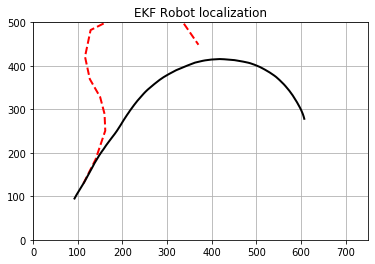

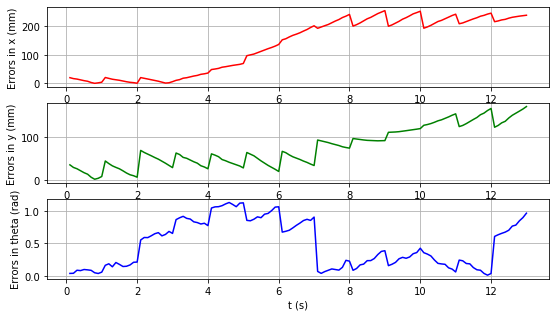

avg_x 133.61327955478637
avg_y 75.52862055179777
avg_theta 0.47778957817102363
std_x 94.33280812574314
std_y 46.33952136581653
std_theta 0.3589291443771741


NameError: ignored

In [0]:
'''
initialize and test case
'''
if __name__ == "__main__":
    L = 750.0 
    W = 500.0 
    r = 25.0 #mm
    l = 90.0 #mm
    std_an = 130 * 2 * np.pi / 60.0 * 0.05         
    std_r = 1200 * 0.03            
    std_b = np.radians(0.1)        
    x_init = np.array([90, 90, np.pi / 3, 0])
    Q = np.diag([0.01, 0.01, 0, 0])
    M = np.diag([std_an**2, std_an**2])
    R = np.diag([std_r**2, std_r**2, std_b**2, std_b**2])
    dt = 1.0
    u_dict = {}
    for n in range(130):
        if n < 50:
            u_dict[n] = [2.0, 2,2]
        elif n < 130:
            u_dict[n] = [2.9, 2.0]
        elif n < 160:
            u_dict[n] = [3.5, 2.0]
        elif n < 210:
            u_dict[n] = [4.5, 1.0]
        else:
            u_dict[n] = [1.0, 4.5]
    
    move_x, update_x = run_localization(x_init, u_dict, dt, M, R, Q, std_r, std_b, std_an)
    
    avg_x, avg_y, avg_theta, std_x, std_y, std_theta = accuracy(move_x, update_x, show=True)
    print('avg_x ' + str(avg_x))
    print('avg_y ' + str(avg_y))
    print('avg_theta ' + str(avg_theta))
    print('std_x ' + str(std_x))
    print('std_y ' + str(std_y))
    print('std_theta ' + str(std_theta))
    generate_ideal_noisy_traj(x, cmds, 1.0, 10, std_an)   
    sensor_traces(x, cmds, 1.0, 10, std_an, std_r, std_b)